In [1]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Formula E

In [3]:
train_data = pd.read_csv("C:/Users/user/Documents/Bayes/ARP/ARP Topic/Codes/Codes/formulae_train_data.csv", encoding='ISO-8859-1')
prediction_data = pd.read_csv("C:/Users/user/Documents/Bayes/ARP/ARP Topic/Codes/Codes/formulae_test_data.csv", encoding='ISO-8859-1')

In [7]:
def preprocess_text(text):
    # Replace NaN values with empty strings
    text = str(text) if pd.notnull(text) else ''
    # Remove special characters and formatting using regular expressions
    text = re.sub(r'\n', ' ', text)  # Replace newlines with spaces
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters except spaces
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word.lower() not in stopwords.words('english')]
    
    # Process the filtered text with spaCy for POS tagging
    doc = nlp(" ".join(filtered_tokens))
    
    # Create a list of token information (word/POS_tag/POS)
    processed_tokens = [f"{token.text}/{token.tag_}/{token.pos_}" for token in doc]
    
    # Join the processed tokens back into a sentence
    processed_text = " ".join(processed_tokens)
    
    return processed_text

# Apply the preprocessing function to the 'Comment' column of your train dataset
train_data['Processed_comment'] = train_data['Comment'].apply(preprocess_text)

# Apply the preprocessing function to the 'Comment' column of your test dataset
prediction_data['Processed_comment'] = prediction_data['Comment'].apply(preprocess_text)

In [10]:
#prediction_data.info()

## Naive Bayes Model

In [11]:
# Convert the training text data to a numerical representation using CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_data['Processed_comment'])  # Use 'Processed_comment' with a lowercase 'c'
y_train = train_data['Age_Group']

# Create and train a Multinomial Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)
with open('naive_bayes_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('vectorizer.pkl', 'rb') as vectorizer_file:
    loaded_vectorizer = pickle.load(vectorizer_file)
with open('naive_bayes_model.pkl', 'rb') as model_file:
    loaded_clf = pickle.load(model_file)

# Convert the prediction text data to the same numerical representation
X_pred = loaded_vectorizer.transform(prediction_data['Processed_comment'])
predicted_ages = loaded_clf.predict(X_pred)
prediction_data['predicted_age'] = predicted_ages
prediction_data.to_csv('FormulaE_naive_bayes_predictions.csv', index=False)

In [12]:
# Perform cross-validation and get cross-validated accuracy scores
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')

# Print the accuracy scores for each fold and the mean accuracy
print("Cross-validated accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validated accuracy scores: [0.375 0.375 0.125 0.25  0.5  ]
Mean accuracy: 0.325


In [25]:
prediction_data = pd.read_csv("C:/Users/user/Documents/Bayes/ARP/ARP Topic/Codes/Codes/FormulaE_naive_bayes_predictions.csv", encoding='utf-8')

In [26]:
age_group_counts = prediction_data['predicted_age'].value_counts()
print("Age Group Counts:")
print(age_group_counts)

Age Group Counts:
20    13
10     1
Name: predicted_age, dtype: int64


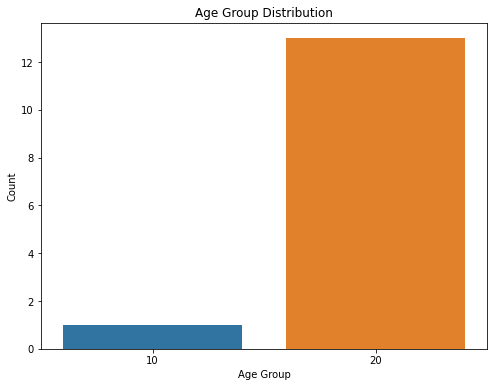

In [27]:
plt.figure(figsize=(8, 6))
sns.countplot(x='predicted_age', data=prediction_data)
plt.title("Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

The model predicts that most people interested in Maserati's Formula E are likely to be in their twenties for data collected through blogs

## TD-IDF with Naive Bayes

In [20]:
# Vectorize the comments using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['Processed_comment'])

# Train a Multinomial Naive Bayes classifier on the entire dataset
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tfidf, train_data['Age_Group'])

# Vectorize the comments in the prediction dataset using the same TF-IDF vectorizer
X_pred_tfidf = tfidf_vectorizer.transform(prediction_data['Processed_comment'])

predicted_ages = naive_bayes_classifier.predict(X_pred_tfidf)
prediction_data['predicted_age'] = predicted_ages
prediction_data.to_csv('FormulaE_TDIDF_predicted_ages.csv', index=False)

In [21]:
cross_val_scores = cross_val_score(naive_bayes_classifier, X_train_tfidf, train_data['Age_Group'], cv=5)
print("Average cross-validation accuracy:", np.mean(cross_val_scores))

Average cross-validation accuracy: 0.325


In [22]:
# Evaluate the classifier on the training data
y_pred = clf.predict(X_train)
print("Training accuracy:", accuracy_score(y_train, y_pred))
print(classification_report(y_train, y_pred))

Training accuracy: 0.475
              precision    recall  f1-score   support

          10       0.00      0.00      0.00         7
          20       0.38      1.00      0.55        13
          30       1.00      0.36      0.53        11
          40       1.00      0.22      0.36         9

    accuracy                           0.48        40
   macro avg       0.60      0.40      0.36        40
weighted avg       0.62      0.47      0.41        40



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
prediction_data = pd.read_csv("C:/Users/user/Documents/Bayes/ARP/ARP Topic/Codes/Codes/FormulaE_TDIDF_predicted_ages.csv", encoding='utf-8')

In [24]:
age_group_counts = prediction_data['predicted_age'].value_counts()
print("Age Group Counts:")
print(age_group_counts)

Age Group Counts:
20    14
Name: predicted_age, dtype: int64


It appears that both the Naive Bayes model and the Naive Bayes model with TF-IDF feature extraction have similar mean cross-validated accuracy scores of approximately 0.325. This suggests that the addition of TF-IDF may not have significantly improved the model's performance in terms of accuracy.

## Logistic Regression

In [28]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data['Processed_comment'])
X_pred = vectorizer.transform(prediction_data['Processed_comment'])

# Train a Logistic Regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, train_data['Age_Group'])

predicted_ages = clf.predict(X_pred)
prediction_data['predicted_age'] = predicted_ages
prediction_data.to_csv('FormulaE_LR_age_classification', index=False)

In [29]:
cross_val_scores = cross_val_score(clf, X_train, train_data['Age_Group'], cv=5)
print("Average cross-validation accuracy:", np.mean(cross_val_scores))

Average cross-validation accuracy: 0.3


## Logistic Regression - N-gram Vectorization

In [30]:
# Convert the training text data to a numerical representation using CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
X_train = vectorizer.fit_transform(train_data['Processed_comment'])
y_train = train_data['Age_Group']

# Create and train a Logistic Regression classifier
clf = LogisticRegression(max_iter=1000, C=1.0, penalty='l2', solver='liblinear')
clf.fit(X_train, y_train)

X_pred = vectorizer.transform(prediction_data['Processed_comment'])
predicted_ages = clf.predict(X_pred)

In [31]:
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Average cross-validation accuracy:", np.mean(cross_val_scores))

Average cross-validation accuracy: 0.25
